![](https://images.pexels.com/photos/1766838/pexels-photo-1766838.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# Apriltag Camera Calibration

Kevin J. Walchko, Phd

12 July 2020

---

A checkerboard target is one of the best calibration target for a camera. The problem becomes, you need to fit the entire target into the image. This leads to the edges not getting a large sampling and the point *coverage* mainly being in the center of the image (camera FOV).

Once you have a calibrated camera, you can calculate the camera distance to a known target. Here, we will use an apriltag to estimate the camera distance from the tag.

## References

- Rosebrock: [Find distance from camera to object/marker using Python and OpenCV](https://www.pyimagesearch.com/2015/01/19/find-distance-camera-objectmarker-using-python-opencv/)

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

# plotting
%matplotlib inline 

In [2]:
%matplotlib inline
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

from matplotlib import pyplot as plt
import pylab                                 
pylab.rcParams['figure.figsize'] = (12.0, 6.0)

import cv2
import time
from pupil_apriltags import Detector
from glob import glob

In [3]:
from opencv_camera import CameraCalibration
from opencv_camera import gray2bgr, rgb2gray
from opencv_camera import mosaic
from opencv_camera import coverage
from opencv_camera import UnDistort
from opencv_camera import SaveVideo
from opencv_camera import visualizeDistortion
from opencv_camera import computeReprojectionErrors
from opencv_camera import visualizeReprojErrors
from opencv_camera import ApriltagFinder
from opencv_camera import visualizeApriltagDetections
from opencv_camera import ApriltagMarker
from opencv_camera import drawHorizontalLines
from opencv_camera import __version__ as VERSION

print(f">> opencv_camera version: {VERSION}")

>> opencv_camera version: 0.10.10


In [5]:
fnames = glob("large_dataset/cals/iphone/*.HEIC")
fnames.sort()
print(f"Found {len(fnames)} images")

Found 54 images


In [6]:
# Image are from an iPhone, so they are stored in the HEIC format. Since
# this is a really good, high compression format, I kept them in this format.
# Changing to JPEG or PNG produced a much larger file size and I need to set
# the compress too high to keep similar performance with the HEIC.
from PIL import Image

# macOS: brew install libffi libheif
# linux: apt install libffi libheif-dev libde265-dev
from pyheif_pillow_opener import register_heif_opener
register_heif_opener()

fimgs = []

for f in fnames:
    im = Image.open(f)
    im = np.array(im)
    im = rgb2gray(im)
    fimgs.append(im)
    
print(f"size: {fimgs[0].shape}")

size: (3024, 4032)


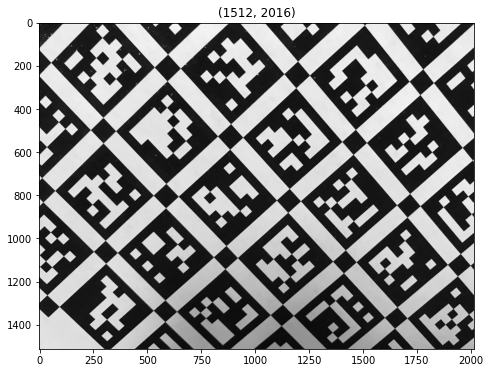

In [18]:
# these are large images, let's scale them down so things
# run faster.
imgs = []
scale = 2
for im in fimgs:
    # additionally, I do a binary thresholding which greatly reduces 
    # the apriltag's bad corner finding which resulted in non-square
    # tags which gave horrible calibration results.
    #ok,im = cv2.threshold(im,90,255,cv2.THRESH_BINARY) # done in library now
    im = cv2.resize(
        im, 
        (im.shape[1]//scale,im.shape[0]//scale,), 
        interpolation=cv2.INTER_NEAREST)
    imgs.append(im)

im = imgs[6]
plt.imshow(im, cmap="gray")
plt.title(f"{im.shape}");

## Calibrate

Each tag in the printed target is 23.5mm or 0.0235m on a side.

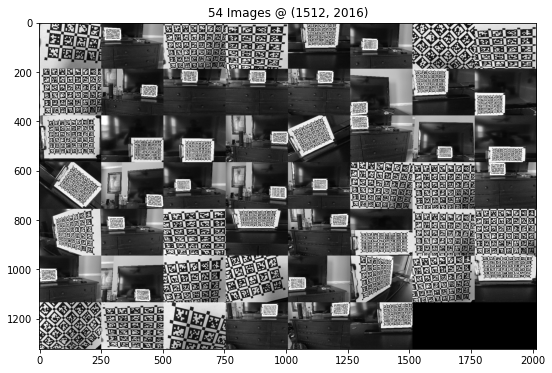

In [19]:
plt.imshow(mosaic(imgs), cmap="gray")
plt.title(f"{len(imgs)} Images @ {imgs[0].shape}");

In [26]:
# create a tag dector
detect = Detector(
        families='tag36h11',
#         nthreads=1,
#         quad_decimate=4,
#         quad_sigma=0.10,
#         refine_edges=1,
#         decode_sharpening=0.20,
        debug=0)

calibrator = CameraCalibration()
board = ApriltagFinder(detect,(6,8), 0.0235)

flags = 0
# flags |= cv2.CALIB_THIN_PRISM_MODEL
# flags |= cv2.CALIB_TILTED_MODEL
# flags |= cv2.CALIB_RATIONAL_MODEL

# dict_keys(['date', 'markerType', 'markerSize', 'imageSize', 
# 'K', 'd', 'rms', 'rvecs', 'tvecs', 'objpoints', 'imgpoints'])
cam, cal = calibrator.calibrate(imgs, board, flags=flags)

# --------------------------------------------------------------
found = 0
totalimgs = len(cal["objpoints"])
totalcorner = 6*8*4*totalimgs
for pts in cal["objpoints"]:
    found += len(pts)

print(f">> Found {found}/{totalcorner} or {100*found/(totalcorner):0.1f}% of corner points")

100%|██████████| 54/54 [00:01<00:00, 48.84it/s]


>> Could not find markers in images: [6, 26, 27, 50, 51]
>> RMS: 2.48px

 Camera[(1512, 2016)]----------------------
  focalLength(x,y): 1667.0 1669.7 px 
  principlePoint(x,y): 964.1 788.8 px
  distortionCoeffs: [[ 0.036 -0.15   0.002 -0.002  0.12 ]]

>> Found 7148/9408 or 76.0% of corner points


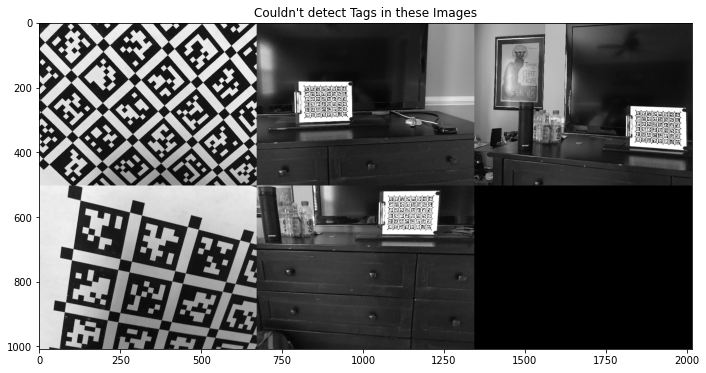

In [27]:
# Let's grab and display the "bad" images we couldn't find
# tags in for some reason.
bi = []
for i in cal["badImages"]:
    bi.append(imgs[i])
bad_imgs = mosaic(bi)
plt.imshow(bad_imgs, cmap="gray")
plt.title("Couldn't detect Tags in these Images");

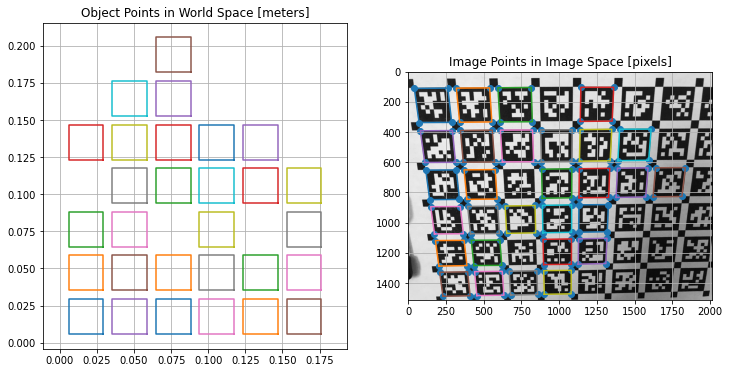

In [28]:
imgnum = 2
# any bad images throw this indexing off imgpts|objpts < imgs
visualizeApriltagDetections(cal["objpoints"][imgnum], cal["imgpoints"][imgnum], imgs[imgnum])

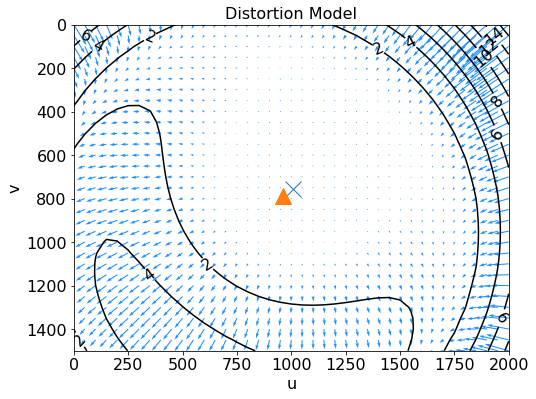

In [29]:
h,w = cam.shape
visualizeDistortion(cam.K, cam.d,h,w,nstep=50)

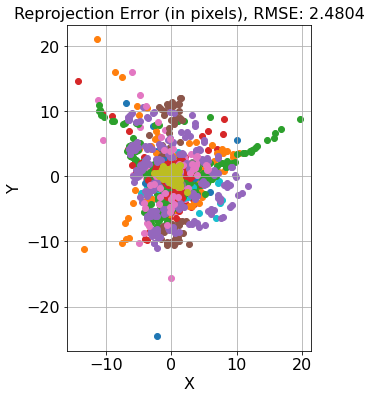

In [30]:
em,rms,xy = computeReprojectionErrors(
    cal["imgpoints"], cal["objpoints"], 
    cal["rvecs"], cal["tvecs"], 
    cal["K"], cal["d"])

visualizeReprojErrors(em, rms, xy,legend=False)

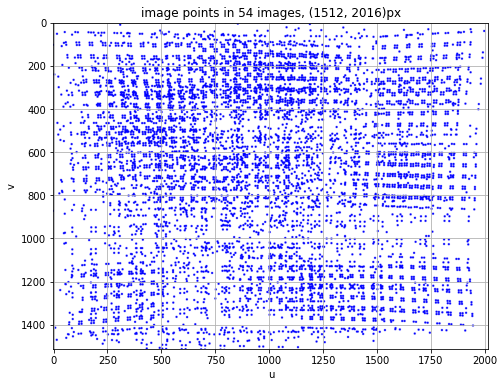

In [31]:
# the focal plane is covered by target corners (shown in blue). Ideally we would
# want all of the black covered, especially around the edegs and corners.
tgt = coverage(cal["imageSize"], cal["imgpoints"])
plt.imshow(tgt)
plt.ylabel("v")
plt.xlabel("u")
plt.grid(True)
plt.title(f"image points in {len(imgs)} images, {imgs[0].shape}px");

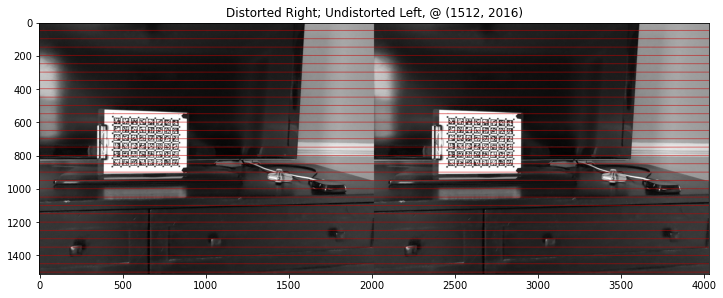

In [32]:
un = UnDistort(cam.K, cam.d, *cam.shape)

image = imgs[5]
better = drawHorizontalLines(image,un.undistort(image,0), thickness=2,step=50)

plt.imshow(better, cmap='gray');
plt.title(f'Distorted Right; Undistorted Left, @ {image.shape}');

In [17]:
# https://en.wikipedia.org/wiki/Curve_orientation#Orientation_of_a_simple_polygon
# cw < 0
# ccw > 0
tcw = lambda a,b,c: (b[0]*c[1]+a[0]*b[1]+a[1]*c[0])-(a[1]*b[0]+b[1]*c[0]+a[0]*c[1]) < 0

# tcw(*vv[:3])

In [266]:
# a=vv[:3].copy()
# a.reverse()
# tcw(*a)

# Range to Camera

Given a camera matrix and knowing the width of the object in the real world, we can calculate the camera distance from it.

$$
D_{m} = w_{m}*f_{px}/w_{px}
$$

where $D$ is distance in meters, $f$ is the focal length in the x-direction in pixels, and $w$ is the objects width in either meters or pixels.

The result is pretty close to accuarate, but I didn't test this extensively.

>> Found 33 tags
Mean: 0.197m  Std: 0.004m


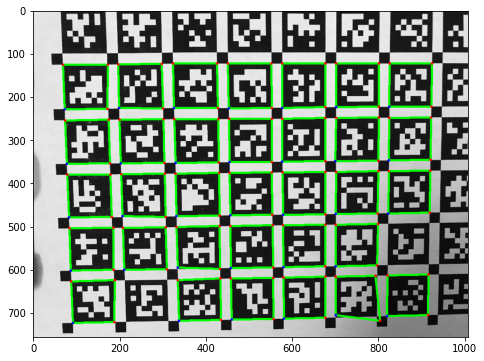

In [267]:
# grab an image
im = imgs[8].copy()

d = Detector(families='tag36h11',
        nthreads=1,
        quad_decimate=12.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.20,
        debug=0)

"""
fx is the mtx[0][0] location
array([[3375.2,    0. , 1998.2],
       [   0. , 3368.8, 1501. ],
       [   0. ,    0. ,    1. ]])
"""

K = cal["K"]
K = [K[0][0],K[1][1],K[0][2],K[1][2]]

tags = d.detect(
    im, estimate_tag_pose=True, 
    camera_params=K, tag_size=0.0235)

print(f">> Found {len(tags)} tags")
# stags = {t.tag_id: t for t in tags}

cim = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
tm = TagMarker()

cim = tm.draw(cim, tags)
plt.imshow(cim);

cam_dist = lambda d,f,a,b: d*f/abs(a - b)

f_x = K[0]
dist = []
for t in tags:
    c = t.corners
    d = cam_dist(0.0235, f_x, c[0][0], c[1][0])
    dist.append(d)
    
print(f"Mean: {np.mean(dist):0.3f}m  Std: {np.std(dist):0.3f}m")

## Image and Tag Size Sensitivity

Image info: (1512, 2016)
>> Found 44 tags


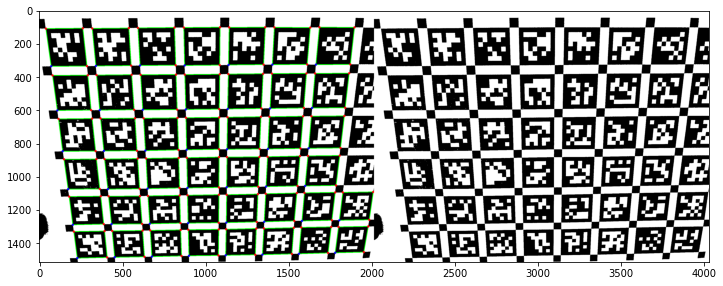

In [40]:
# grab an image - 35
# - 41
im = imgs[2].copy()
print(f"Image info: {im.shape}")
# im = cv2.equalizeHist(im)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# im = clahe.apply(im)
ok,im = cv2.threshold(im,90,255,cv2.THRESH_BINARY)


# If the image is too big, then the detect seems to fail in finding
# all of the tags. Decimating the image seems to help with large
# images/tags.
d = Detector(families='tag36h11',
#         nthreads=4,
        quad_decimate=8.0,
#         quad_sigma=0.0,
#         refine_edges=1,
#         decode_sharpening=0.20,
        debug=0)

tags = d.detect(
    im, 
    estimate_tag_pose=False, 
    camera_params=None, 
    tag_size=0.0235)

print(f">> Found {len(tags)} tags")

cim = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
orig = cim.copy()
tm = ApriltagMarker()

cim = tm.draw(cim, tags)
plt.imshow(np.hstack((cim,orig)));